In [1]:
# -------------------------------------------------------------------------------------
# Third party imports
# -------------------------------------------------------------------------------------
import numpy as np 
import matplotlib
import matplotlib.pyplot as plt
import os, sys
import glob 
import copy

import astropy
from astropy.io import fits
from astropy.time import Time
from astropy.units import allclose as quantity_allclose
from astropy import units as u
from astropy import constants as c
from astropy.coordinates import SkyCoord
from astropy.coordinates.builtin_frames import FK5, ICRS, GCRS, GeocentricMeanEcliptic, BarycentricMeanEcliptic, HeliocentricMeanEcliptic, GeocentricTrueEcliptic, BarycentricTrueEcliptic, HeliocentricTrueEcliptic, HeliocentricEclipticIAU76
from astropy.constants import R_sun, R_earth
from astropy.nddata import CCDData
from tqdm import tnrange

from datetime import datetime
import copy
import numpy as np

from astropy.io import fits
from astropy import wcs
from astropy.nddata import CCDData
from ccdproc import wcs_project  # , Combiner

from matplotlib.colors import LogNorm

#from IPython.display import display, Markdown, clear_output

import inspect
import importlib
import warnings
warnings.filterwarnings('ignore')

# Plot setup
matplotlib.rc('font', size=12, family='sans serif', weight='bold')
plt.rcParams['figure.figsize'] = [10, 4]
np.printoptions(suppress=True)

In [2]:
# Local imports
sys.path.append(os.path.join(os.path.split(os.getcwd())[0], 'shifty'))
import imagehandler
import transformer

In [5]:
%%time
importlib.reload(imagehandler)
#filenames=sorted(glob.glob('./clean02_?_???.fits'))
filenames=sorted(glob.glob('./clean03_????.fits'))
print(f"{len(filenames)} files")
D=imagehandler.DataHandler(filenames, extno=0, EXPTIME='EXPOSURE', EXPUNIT='d', MAGZERO=18.,
                           MJD_START='BJDREFI+TSTART+-2400000.5', GAIN='GAINA', FILTER='-Tess', verbose=False,
                           xycuts=[900,1200,1400,1700])
                           #)
times = np.array([dh['SHIFTY_MJD_MID'] for dh in D.image_data.header]) + 2400000.5

1108 files
Reading image 1107: ./clean03_1107.fits
Read 1108 files!
Done!
CPU times: user 38.4 s, sys: 6.72 s, total: 45.1 s
Wall time: 2min 56s


In [177]:
# Define ABG
alpha = 0.0
beta = 0.0
gamma = 0.01190665
gamma = 0.5*Delta_gamma
alpha_dot = 0.01046425
alpha_dot = Delta_alpha_dot*8
beta_dot = 0.00007661
beta_dot = 0.0
gamma_dot = 0.0
abg = np.array([alpha, beta, gamma, alpha_dot, beta_dot, gamma_dot])

# Define reference time
time0 = times[0]

# Just put the reference latlon at the center of WCS
x_pix0 = D.image_data.header[0]['CRPIX1']
y_pix0 = D.image_data.header[0]['CRPIX2']
radec0 = D.image_data.WCS[0].all_pix2world(x_pix0, y_pix0, 0)
latlon0 = np.array(transformer.eq_to_ec(np.radians(radec0[0]),
                                        np.radians(radec0[1]))).T

In [178]:
%%time
importlib.reload(transformer)
T=transformer.Transformer(times, '500@-95', 'JPL')
shift_abg = T(abg, time0, latlon0, D.image_data.WCS)
print(shift_abg)
print(T._get_light_travel_times())

[[1001.0012236  1045.08724829]
 [1001.0040746  1045.15404728]
 [1001.0068797  1045.22089506]
 ...
 [ 999.74372772 1123.94392119]
 [ 999.74179477 1124.00265357]
 [ 999.73990137 1124.06132643]]
0.0007906253704910328
CPU times: user 599 ms, sys: 2.65 ms, total: 601 ms
Wall time: 683 ms


In [ ]:
%%time
D.integer_shift(-shift_abg, padmean=True)

In [71]:
%%time
D.stack(shifted=True, median_combine=True)

Combining images using median stacking.
CPU times: user 5min 53s, sys: 670 µs, total: 5min 53s
Wall time: 6min 16s


In [72]:
%%time
D.save_stack(f'stack_{alpha}_{beta}_{gamma}_{alpha_dot}_{beta_dot}_{gamma_dot}.fits')


Done!
CPU times: user 37.5 ms, sys: 0 ns, total: 37.5 ms
Wall time: 40.1 ms


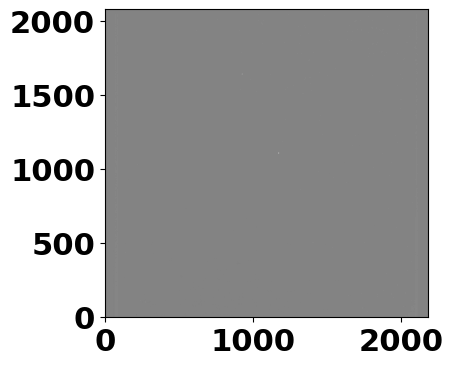

In [154]:
plt.imshow((D.stacked_data.data-np.nanmin(D.stacked_data.data)),
           origin='lower', cmap='gray',norm=LogNorm())

# WTF?

In [40]:
%%time
importlib.reload(imagehandler)
#filenames=sorted(glob.glob('./clean02_?_???.fits'))
filenames=sorted(glob.glob('./clean03_????.fits'))
print(f"{len(filenames)} files")
D=imagehandler.DataHandler(filenames, extno=0, EXPTIME='EXPOSURE', EXPUNIT='d', MAGZERO=18.,
                           MJD_START='BJDREFI+TSTART+-2400000.5', GAIN='GAINA', FILTER='-Tess', verbose=False,
                           #xycuts=(900,1200,1400,1700))
                           #xycuts=(1090,1100,1590,1600))
                           )
times = np.array([dh['SHIFTY_MJD_MID'] for dh in D.image_data.header]) + 2400000.5

1108 files
Reading image 1107: ./clean03_1107.fits
Read 1108 files!
Done!
CPU times: user 41.6 s, sys: 17.4 s, total: 59 s
Wall time: 6min 6s


In [5]:
# Calculate step size in alpha_dot and gamma (Delta_beta_dot == Delta_alpha_dot)
Delta_alpha_dot = np.radians(21/3600)/(27/365.24)  # from Holman et al 2019 (Feasibility Study)
Delta_gamma = 1/25   # Derived from equation 2 in Holman et al 2019 (Feasibility Study)
print(f"Delta_alpha_dot={Delta_alpha_dot:7.5} radians/year, Delta_gamma={Delta_gamma} au^-1)")

Delta_alpha_dot=0.0013772 radians/year, Delta_gamma=0.04 au^-1)


In [25]:
# Define ABG
alpha = 0.0
beta = 0.0
gamma = 0.01190665
alpha_dot = 0.01046425
beta_dot = 0.00007661
gamma_dot = 0.0
abg = np.array([alpha, beta, gamma, alpha_dot, beta_dot, gamma_dot])

# Define reference time
time0 = times[0]

# Just put the reference latlon at the center of WCS
x_pix0 = D.image_data.header[0]['CRPIX1']
y_pix0 = D.image_data.header[0]['CRPIX2']
radec0 = D.image_data.WCS[0].all_pix2world(x_pix0, y_pix0, 0)
latlon0 = np.array(transformer.eq_to_ec(np.radians(radec0[0]),
                                        np.radians(radec0[1]))).T

In [26]:
importlib.reload(transformer)
T=transformer.Transformer(times, '500@-95', 'JPL')

NameError: name 'Delta_alpha_dot' is not defined

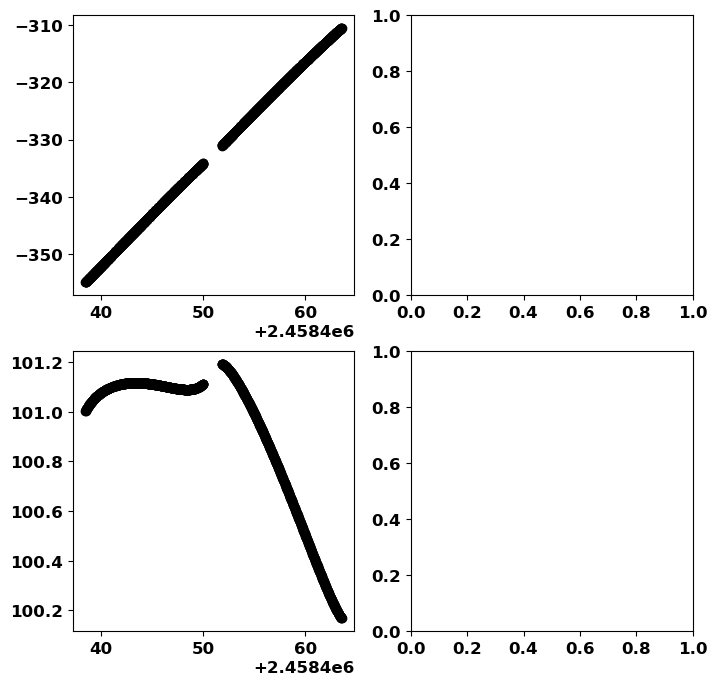

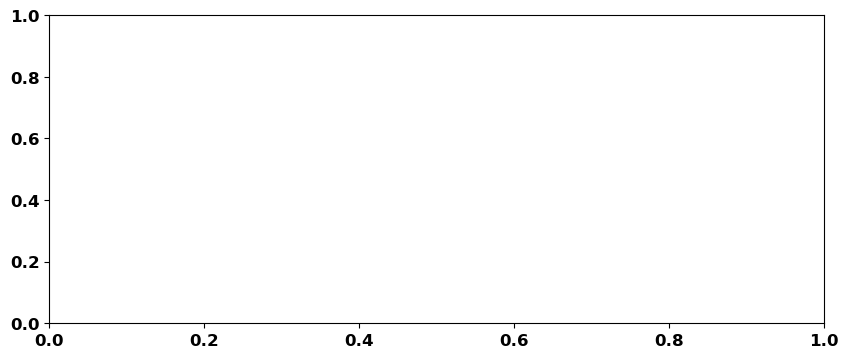

In [27]:
%%time
# Define ABG
alpha = 0.0
beta = 0.0
gamma = 0.01190665
alpha_dot = 0.01046425
beta_dot = 0.00007661
gamma_dot = 0.0
abg = np.array([alpha, beta, gamma, alpha_dot, beta_dot, gamma_dot])

shift_abg = T(abg, time0, latlon0, D.image_data.WCS)

fig,ax=plt.subplots(2,2, figsize=(8,8))
fig2,ax2=plt.subplots(1,1)
#plt.plot(shift_abg[:,1], shift_abg[:, 0], 'ok')
ax[0, 0].plot(times,shift_abg[:,1], 'ok')
ax[1, 0].plot(times,shift_abg[:,0], 'ok', label="Sedna (0.01190665)")

da = [-4, 0, 5]
#for gamma_tmp in np.arange(0., Delta_alpha_dot*1.01, Delta_alpha_dot):
for i, gamma_tmp in enumerate(np.arange(0.011, 0.0131, 0.001)):
    abg_tmp = copy.deepcopy(abg)
    abg_tmp[2] = gamma_tmp
    #abg_tmp[3] += 6.45*(gamma_tmp - 0.01190665)
    #abg_tmp[4] -= 0.15*(gamma_tmp - 0.01190665)
    abg_tmp[3] += da[i]*Delta_alpha_dot
    shift=T(abg_tmp, time0, latlon0, D.image_data.WCS)
    #plt.plot(shift[:,1]-shift_abg[:,1], shift[:, 0]-shift_abg[:, 0], '+')
    #plt.plot(shift[:,1], shift[:, 0], '+')
    ax[0, 0].plot(times, shift[:, 1], '.')
    ax[1, 0].plot(times, shift[:, 0], '.', label=f'gamma={gamma_tmp:5.3f}')
    ax[0, 1].plot(times, shift[:, 1]-shift_abg[:, 1], '.')
    ax[1, 1].plot(times, shift[:, 0]-shift_abg[:, 0], '.')
    ax2.plot(shift[:,1]-shift_abg[:,1], shift[:, 0]-shift_abg[:, 0], '.')
    #print(shift)

ax[0, 0].set_ylabel('x-pixel')
ax[0, 0].set_xlabel('Date (JD)')
ax[1, 0].set_ylabel('y-pixel')
ax[1, 0].set_xlabel('Date (JD)')
ax[0, 1].set_ylabel('Delta_x (pixels)')
ax[0, 1].set_xlabel('Date (JD)')
ax[1, 1].set_ylabel('Delta_y (pixels)')
ax[1, 1].set_xlabel('Date (JD)')
ax2.set_ylabel('Delta_y (pixels)')
ax2.set_xlabel('Delta_x (pixels)')
ax[1, 0].legend(prop={'size':8})
fig.savefig('gamma_steps_xy_vs_time.png')
fig2.savefig('gamma_steps_xy_motion.png')

0.09530956406313265
CPU times: user 681 ms, sys: 5.07 ms, total: 686 ms
Wall time: 696 ms


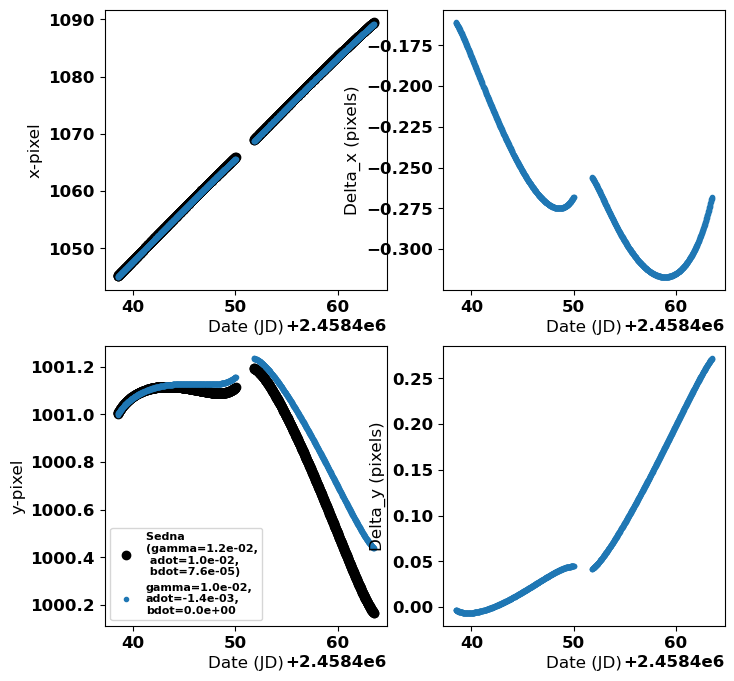

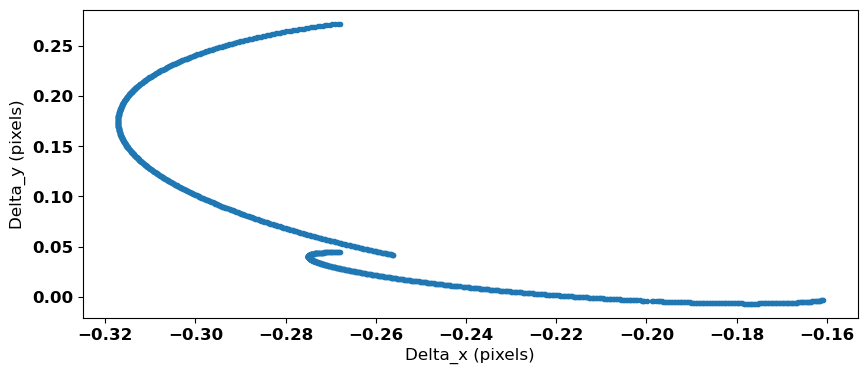

In [258]:
%%time
# Define ABG
alpha = 0.0
beta = 0.0
gamma = 0.01190665
alpha_dot = 0.01046425
beta_dot = 0.00007661
gamma_dot = 0.0
abg = np.array([alpha, beta, gamma, alpha_dot, beta_dot, gamma_dot])

shift_abg = T(abg, time0, latlon0, D.image_data.WCS)

fig,ax=plt.subplots(2,2, figsize=(8,8))
fig2,ax2=plt.subplots(1,1)
#plt.plot(shift_abg[:,1], shift_abg[:, 0], 'ok')
ax[0, 0].plot(times,shift_abg[:,1], 'ok')
ax[1, 0].plot(times,shift_abg[:,0], 'ok', label="Sedna \n(gamma=1.2e-02,\n adot=1.0e-02,\n bdot=7.6e-05)")

abg_tmp = copy.deepcopy(abg)
abg_tmp[2] = 0.01

abg_tmp[3] = Delta_alpha_dot * -1
abg_tmp[4] = Delta_alpha_dot * -0

shift=T(abg_tmp, time0, latlon0, D.image_data.WCS)
#plt.plot(shift[:,1]-shift_abg[:,1], shift[:, 0]-shift_abg[:, 0], '+')
#plt.plot(shift[:,1], shift[:, 0], '+')
ax[0, 0].plot(times, shift[:, 1], '.')
ax[1, 0].plot(times, shift[:, 0], '.', label=f'gamma={abg_tmp[2]:3.1e},\nadot={abg_tmp[3]:3.1e},\nbdot={abg_tmp[4]:3.1e}')
ax[0, 1].plot(times, shift[:, 1]-shift_abg[:, 1], '.')
ax[1, 1].plot(times, shift[:, 0]-shift_abg[:, 0], '.')
ax2.plot(shift[:,1]-shift_abg[:,1], shift[:, 0]-shift_abg[:, 0], '.')
#print(shift)

ax[0, 0].set_ylabel('x-pixel')
ax[0, 0].set_xlabel('Date (JD)')
ax[1, 0].set_ylabel('y-pixel')
ax[1, 0].set_xlabel('Date (JD)')
ax[0, 1].set_ylabel('Delta_x (pixels)')
ax[0, 1].set_xlabel('Date (JD)')
ax[1, 1].set_ylabel('Delta_y (pixels)')
ax[1, 1].set_xlabel('Date (JD)')
ax2.set_ylabel('Delta_y (pixels)')
ax2.set_xlabel('Delta_x (pixels)')
ax[1, 0].legend(prop={'size':8})
fig.savefig('gamma_steps_xy_vs_time.png')
fig2.savefig('gamma_steps_xy_motion.png')

print(np.mean(((shift[:,1]-np.mean(shift,0)[1])-(shift_abg[:,1]-np.mean(shift_abg,0)[1]))**2 + 
             ((shift[:,0]-np.mean(shift,0)[0])-(shift_abg[:,0]-np.mean(shift_abg,0)[0]))**2)**0.5)

In [262]:
def f(timei, adot, bdot):
    s = T([0, 0, 0.02, adot, bdot, 0], time0, latlon0, D.image_data.WCS)
    ss = s - np.mean(s, 0)
    return np.array(list(ss[:,0])+list(ss[:,1]))

In [263]:
import scipy.optimize as spo
sa = shift_abg - np.mean(shift_abg,0)
a=spo.curve_fit(f, times, np.array(list(sa[:,0])+list(sa[:,1])), p0=[45.0*Delta_alpha_dot, -1.0*Delta_alpha_dot])

In [264]:
a[0]/Delta_alpha_dot

array([44.61443796, -0.91932008])

In [41]:
D.integer_shift(-shift_abg, padmean=True)
np.shape(D.shifted_data.data)

(1108, 2079, 2180)

In [36]:
import time
#b=np.random.random([1108,2079,2180])
b=D.shifted_data.data

bn=np.zeros_like(b[0])
start=time.time()
for i in np.arange(np.shape(b)[1]):
  bn[i]=np.median(b[:,i,:], 0)

end=time.time()
print(end-start)

bn=np.zeros_like(b[0])
start=time.time()
for i in np.arange(int(np.ceil(np.shape(b)[1]/100.))):
  j = i * 100
  bn[j:j+100]=np.median(b[:,j:j+100,:], 0)

end=time.time()
print(end-start)

start=time.time()
bn=np.median(b, 0)

end=time.time()
print(end-start)

78.34301519393921
83.15747332572937
102.8633713722229


In [42]:
start=time.time()
D.stack(shifted=True, median_combine=True)
end=time.time()
print(end-start)

Combining images0 1.1920928955078125e-06
1 1.9311904907226562e-05
2 2.7894973754882812e-05
 using median stacking.
3 516.9885625839233
4 516.9892339706421
5 516.9892649650574
6 516.989283323288
7 516.9892911911011
516.9900476932526


In [43]:
start=time.time()
_=np.nanmedian(D.shifted_data.data, 0)
end=time.time()
print(end-start)

511.2557668685913


In [33]:
import time
b=np.random.random([1108,2079,2180])

bn=np.zeros_like(b[0])
start=time.time()
for i in np.arange(np.shape(b)[1]):
  bn[i]=np.median(b[:,i,:], 0)

end=time.time()
print(end-start)

bn=np.zeros_like(b[0])
start=time.time()
for i in np.arange(int(np.ceil(np.shape(b)[1]/100.))):
  j = i * 100
  bn[j:j+100]=np.median(b[:,j:j+100,:], 0)

end=time.time()
print(end-start)

start=time.time()
bn=np.median(b, 0)

end=time.time()
print(end-start)

90.56652188301086
98.0210816860199
116.59794783592224


In [272]:
%%time
D.integer_shift(-shift_abg, padmean=True)
D.stack(shifted=True, median_combine=False)
D.save_stack(f'stack_Sedna_mean.fits')

Combining images using mean stacking

Done!
CPU times: user 1min 11s, sys: 24.7 s, total: 1min 36s
Wall time: 1min 36s


In [278]:
%%time
D.integer_shift(-shift_abg, padmean=True)
D.shifted_data.data = astropy.stats.sigma_clip(D.shifted_data.data, sigma=2, axis=0, cenfunc=np.mean, copy=False, masked=False)
D.stack(shifted=True, median_combine=False)
D.save_stack(f'stack_Sedna_meanclip2.fits')

Combining images using mean stacking

Done!
CPU times: user 4min 20s, sys: 51.2 s, total: 5min 12s
Wall time: 5min 13s


In [279]:
%%time
D.integer_shift(-shift_abg, padmean=True)
D.shifted_data.data = astropy.stats.sigma_clip(D.shifted_data.data, sigma=1, axis=0, cenfunc=np.mean, copy=False, masked=False)
D.stack(shifted=True, median_combine=False)
D.save_stack(f'stack_Sedna_meanclip1.fits')

Combining images using mean stacking

Done!
CPU times: user 4min 40s, sys: 51.4 s, total: 5min 31s
Wall time: 5min 33s


In [281]:
%%time
D.integer_shift(-shift_abg, padmean=True)
D.shifted_data.data = astropy.stats.sigma_clip(D.shifted_data.data, sigma=1.5, axis=0, cenfunc=np.mean, copy=False, masked=False)
D.stack(shifted=True, median_combine=False)
D.save_stack(f'stack_Sedna_meanclip1.5.fits')

Combining images using mean stacking

Done!
CPU times: user 4min 31s, sys: 52.6 s, total: 5min 23s
Wall time: 5min 25s


In [276]:
%%time
D.integer_shift(-shift_abg, padmean=True)
D.stack(shifted=True, median_combine=True)
D.save_stack(f'stack_Sedna_median.fits')

Combining images using median stacking.

Done!
CPU times: user 8min 37s, sys: 14.6 s, total: 8min 52s
Wall time: 8min 56s


In [270]:
%%time
shift=T([0,0,0.1,-1*Delta_alpha_dot,0,0], time0, latlon0, D.image_data.WCS)
D.integer_shift(-shift, padmean=True)
D.stack(shifted=True, median_combine=False)
D.save_stack(f'stack_0.1_-1_0_mean.fits')
D.stack(shifted=True, median_combine=True)
D.save_stack(f'stack_0.1_-1_0_median.fits')

Combining images using mean stacking

Done!
Combining images using median stacking.

Done!
CPU times: user 10min 3s, sys: 29.2 s, total: 10min 33s
Wall time: 10min 37s


In [277]:
%%time
shift=T([0,0,0.02,45*Delta_alpha_dot,-1*Delta_alpha_dot,0], time0, latlon0, D.image_data.WCS)
D.integer_shift(-shift, padmean=True)
D.stack(shifted=True, median_combine=False)
D.save_stack(f'stack_0.2_45_-1_mean.fits')
D.stack(shifted=True, median_combine=True)
D.save_stack(f'stack_0.2_45_-1_median.fits')

Combining images using mean stacking

Done!
Combining images using median stacking.

Done!
CPU times: user 9min 5s, sys: 25 s, total: 9min 30s
Wall time: 9min 34s


In [224]:
%%time
shift_abg = T(abg, time0, latlon0)#, D.image_data.WCS)
rms = []
for i, abg_tmp in enumerate(abgs[:]):
    print(f"{i} of {len(abgs)}", end='\r')
    shift=T(abg_tmp, time0, latlon0)#, D.image_data.WCS)
    diff = (shift-shift_abg)**2
    rms.append(np.sum(diff[:,0]+diff[:,1]))
print(rms)

KeyboardInterrupt: 

In [231]:
print(abgs[np.argmin(rms)])
print(abg)

[0, 0, 0.02, 0.025132741228718343, -0.0013962634015954635, 0]
[0.000000e+00 0.000000e+00 1.190665e-02 1.046425e-02 7.661000e-05
 0.000000e+00]


In [182]:
%%time
for i in np.arange(100000):
    np.mean((shift-shift_abg)[:,0]**2+(shift-shift_abg)[:,1]**2)

CPU times: user 1.91 s, sys: 1.95 ms, total: 1.91 s
Wall time: 2.59 s


In [181]:
%%time
for i in np.arange(100000):
    np.sum((shift-shift_abg)[:,0]**2+(shift-shift_abg)[:,1]**2)

CPU times: user 1.51 s, sys: 2.88 ms, total: 1.52 s
Wall time: 2.1 s


In [41]:
np.max([shift[:,1]-shift_abg[:,1], shift[:, 0]-shift[:, 0]], 1)

array([34.97940512,  0.        ])

# Grid

In [57]:
importlib.reload(imagehandler)
#filenames=sorted(glob.glob('./clean02_?_???.fits'))
filenames=sorted(glob.glob('./clean03_????.fits'))
print(f"{len(filenames)} files")
D=imagehandler.DataHandler(filenames, extno=0, EXPTIME='EXPOSURE', EXPUNIT='d', MAGZERO=18.,
                           MJD_START='BJDREFI+TSTART+-2400000.5', GAIN='GAINA', FILTER='-Tess', verbose=False,
                           xycuts=[900,1200,1400,1700])
                           #)
times = np.array([dh['SHIFTY_MJD_MID'] for dh in D.image_data.header]) + 2400000.5

1108 files
Reading image 1107: ./clean03_1107.fits
Read 1108 files!
Done!


In [ ]:
# Calculate step size in alpha_dot and gamma (Delta_beta_dot == Delta_alpha_dot)
Delta_alpha_dot = np.radians(21/3600)/(27/365.24)  # from Holman et al 2019 (Feasibility Study)
Delta_gamma = 1/25   # Derived from equation 2 in Holman et al 2019 (Feasibility Study)
print(f"Delta_alpha_dot={Delta_alpha_dot:7.5} radians/year, Delta_gamma={Delta_gamma} au^-1)")

In [33]:
%%time

# Define reference time
time0 = times[0]

# Just put the reference latlon at the center of WCS
x_pix0 = D.image_data.header[0]['CRPIX1']
y_pix0 = D.image_data.header[0]['CRPIX2']
radec0 = D.image_data.WCS[0].all_pix2world(x_pix0, y_pix0, 0)
latlon0 = np.array(transformer.eq_to_ec(np.radians(radec0[0]),
                                        np.radians(radec0[1]))).T

# Define ABG
gamma_min = 0.002
gamma_max = 0.152
abgs = []
# Starting at gamma_min (or 0 plus a half stepsize if gamma_min is too close to 0)
# Step through gamma at Delta_gamma steps,
# up to gamma_max plus half stepsize to ensure the step closest to gamma_max is searched.
for gamma in np.arange(np.max([gamma_min-0.5*Delta_gamma,0])+0.5*Delta_gamma,
                       gamma_max+0.5*Delta_gamma,
                       Delta_gamma):
    mean_motion_circular = 2 * np.pi * gamma **1.5
    # sqrt(2) * mean_motion_circular is bound limit, doing slightly beyond in case of interstellar
    #speed_limit = 1.6 * mean_motion_circular
    # Nope, that increases parameterspace by 28 percent, screw interstellar objects (for now)
    speed_limit = (2 ** 0.5) * mean_motion_circular
    N_alpha = np.int(np.ceil(2 * speed_limit / Delta_alpha_dot))
    print(f'gamma={gamma}, {N_alpha**2}')
    for alpha_dot in np.linspace(-speed_limit, speed_limit, N_alpha):
        for beta_dot in np.linspace(-speed_limit, speed_limit, N_alpha):
            # use alpha=beta=0, as they are just offsets relative to the reference direction.
            # use gamma_dot=0, as radial motion doesn't have much effect on 27 day timescale.
            abgs.append([0, 0, gamma, alpha_dot, beta_dot, 0])

gamma=0.02, 1369
gamma=0.06, 36100
gamma=0.09999999999999999, 167281
gamma=0.13999999999999999, 456976
CPU times: user 978 ms, sys: 67.5 ms, total: 1.05 s
Wall time: 1.41 s


In [6]:
print(np.inf,1/0.04, 1/0.08, 1/0.12, 1/0.16)
print(np.array([1764,46225,213444,585225])*10/(24*60))
print(np.array([1369,36100,167281,456976])*10/(24*60))

inf 25.0 12.5 8.333333333333334 6.25
[  12.25        321.00694444 1482.25       4064.0625    ]
[   9.50694444  250.69444444 1161.67361111 3173.44444444]


In [7]:
%%time
'''Defining the Transformer object is only neccessary once, as the Observers motion is always the same'''
T=transformer.Transformer(times, '500@-95', 'JPL')

CPU times: user 483 ms, sys: 12.2 ms, total: 495 ms
Wall time: 1.89 s


In [ ]:
%%time
digit1 = 2 - int(np.floor(np.log10(Delta_gamma)))
digit2 = 2 - int(np.floor(np.log10(Delta_alpha_dot)))
with open('shifts.txt', 'w') as sfile:
    sfile.write('#Alpha,beta,gamma,alpha_dot,beta_dot,gamma_dot,lat0,lon0,time0,x_coo0,y_coo0,x_coo_min,y_coo_min,x_coo_max,y_coo_max,x_coo_-1,y_coo_-1\n')
    for abg in abgs[:]:
        print(f'Shift+stacking for: {abg}')
        shift_abg = T(abg, time0, latlon0, D.image_data.WCS)
        D.integer_shift(-shift_abg, padmean=True)
        D.stack(shifted=True, median_combine=True)
        D.save_stack(f'stack_{abg[0]:{digit1+2}.{digit1}f}_{abg[1]:{digit1+2}.{digit1}f}_{abg[2]:{digit1+2}.{digit1}f}_{abg[3]:{digit2+2}.{digit2}f}_{abg[4]:{digit2+2}.{digit2}f}_{abg[5]:{digit2+2}.{digit2}f}.fits')
        sfile.write(','.join(np.concatenate([abg[:6], latlon0, [time0], shift_abg[0], np.min(shift_abg, 0), np.max(shift_abg, 0), shift_abg[-1]]).astype(str))+'\n')    

Shift+stacking for: [0, 0, 0.02, -0.025132741228718343, -0.025132741228718343, 0]
Combining images using median stacking.

Done!
Shift+stacking for: [0, 0, 0.02, -0.025132741228718343, -0.02373647782712288, 0]
Combining images using median stacking.

Done!
Shift+stacking for: [0, 0, 0.02, -0.025132741228718343, -0.022340214425527416, 0]
Combining images using median stacking.

Done!
Shift+stacking for: [0, 0, 0.02, -0.025132741228718343, -0.020943951023931952, 0]
Combining images using median stacking.

Done!
Shift+stacking for: [0, 0, 0.02, -0.025132741228718343, -0.01954768762233649, 0]
Combining images using median stacking.

Done!
Shift+stacking for: [0, 0, 0.02, -0.025132741228718343, -0.018151424220741025, 0]
Combining images using median stacking.

Done!
Shift+stacking for: [0, 0, 0.02, -0.025132741228718343, -0.016755160819145562, 0]
Combining images using median stacking.

Done!
Shift+stacking for: [0, 0, 0.02, -0.025132741228718343, -0.015358897417550098, 0]
Combining images 

In [148]:
print(','.join(np.concatenate([abg[:6], latlon0, [time0], shift_abg[0], np.min(shift_abg, 0), np.max(shift_abg, 0), shift_abg[-1]]).astype(str))+'\n')

0.0,0.0,0.01190665,0.01046425,7.661e-05,0.0,-0.2104758570785565,0.9887497644929477,2458435.17219,1102.1853612307636,1541.9484179503245,1101.145485265458,1541.9484179503245,1102.2993252209644,1586.9042603356468,1101.145485265458,1586.9042603356468



In [15]:
%%time
importlib.reload(imagehandler)
filenames=sorted(glob.glob('./shift_????.fits'))
print(f"{len(filenames)} files")
D=imagehandler.DataHandler(filenames, extno=0, EXPTIME='EXPOSURE', EXPUNIT='d', MAGZERO=18.,
                           MJD_START='BJDREFI+TSTART+-2400000.5', GAIN='GAINA', FILTER='-Tess', verbose=False,)
times = np.array([dh['SHIFTY_MJD_MID'] for dh in D.image_data.header]) + 2400000.5

100 files
Reading image 99: ./shift_0099.fits
Read 100 files!
Done!
CPU times: user 4.11 s, sys: 1.01 s, total: 5.12 s
Wall time: 19.3 s


In [16]:
D.shifted_data = D.image_data

In [17]:
%%time
D.stack(shifted=True, median_combine=True, save_to_filename='tst.fits', which_WCS='middle')

Combining images using median stacking.

Done!
CPU times: user 52.8 s, sys: 25.7 ms, total: 52.8 s
Wall time: 55.7 s


In [24]:
np.floor(np.log10(Delta_alpha_dot))

-3.0

In [36]:
np.round(2.5*Delta_alpha_dot,2-int(np.floor(np.log10(Delta_alpha_dot))))

0.00344

In [49]:
a=(2-int(np.floor(np.log10(Delta_alpha_dot))))
print(f'{Delta_alpha_dot:{a}.{a}f}')

0.00138


In [40]:
a

5

In [55]:
digit1 = 2-int(np.floor(np.log10(Delta_gamma)))
digit2 = 2-int(np.floor(np.log10(Delta_alpha_dot)))

f'stack_{abg[0]:{digit1+2}.{digit1}f}_{abg[1]:{digit1+2}.{digit1}f}_{abg[2]:{digit1+2}.{digit1}f}_{abg[3]:{digit2+2}.{digit2}f}_{abg[4]:{digit2+2}.{digit2}f}_{abg[5]:{digit2+2}.{digit2}f}.fits'

'stack_0.0000_0.0000_0.0119_0.01046_0.00008_0.00000.fits'

In [52]:
abg[2]

0.01190665